# Autor: Cristóbal Arroyo

# Imports and setups

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('spanish')

wpt = nltk.WordPunctTokenizer()
lmt = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /home/agali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/agali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df_original = pd.read_excel('./ODScat_345.xlsx')
df_original.columns

Index(['Textos_espanol', 'sdg'], dtype='object')

In [4]:
# Check null data
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  4049 non-null   object
 1   sdg             4049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.4+ KB


# Preparación de datos

In [5]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'a',
        'Ã©': 'e',
        'Ã­': 'i',
        'Ã³': 'o',
        'Ãº': 'u',
        'Ã±': 'ñ'
    }

    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)

    return text

df_original['Textos_espanol'] = df_original['Textos_espanol'].apply(fix_encoding)

In [6]:
corpus = np.array(df_original['Textos_espanol'])

In [7]:
def normalize_documents(doc):
    # Remove lower case and special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    doc = doc.lower()
    doc = doc.strip()

    tokens = wpt.tokenize(doc)
    #filtered_tokens = [lmt.lemmatize(token) for token in tokens if token not in stop_words]
    filtered_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)

    return doc

normalize_corpus = np.vectorize(normalize_documents)
norm_corpus = normalize_corpus(corpus)

In [8]:
df_cleaned = df_original.copy()
df_cleaned['Clean_Text'] = norm_corpus

In [9]:
original_words = WordCloud(width=1200, height=400, background_color='white').generate(' '.join(corpus))
cleaned_words = WordCloud(width=1200, height=400, background_color='white').generate(' '.join(norm_corpus))

### Visualización de palabras comunes con y sin stop words

<Figure size 640x480 with 0 Axes>

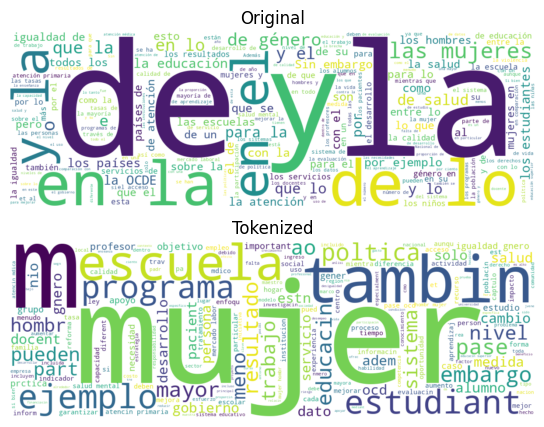

In [10]:
plt.figure()

f, axes = plt.subplots(2, 1, figsize=(15, 5))

axes[0].imshow(original_words, interpolation='bilinear')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(cleaned_words, interpolation='bilinear')
axes[1].set_title('Tokenized')
axes[1].axis('off')

plt.show()


### Visualización de palabras por categoría

In [11]:
category_words = {}
for category in df_cleaned['sdg'].unique():
    category_words[category] = ' '.join(df_cleaned[df_cleaned['sdg'] == category]['Clean_Text'])

<Figure size 1500x1000 with 0 Axes>

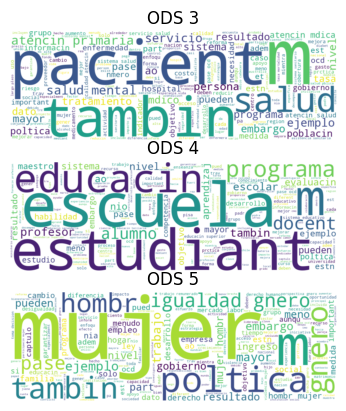

In [12]:
plt.figure(figsize=(15, 10))

f, axes = plt.subplots(3, 1)

for i, category in enumerate(df_cleaned['sdg'].unique()):
    axes[i].imshow(WordCloud(width=1200, height=400, background_color='white').generate(category_words[category]), interpolation='bilinear')
    axes[i].set_title(f'ODS {category}')
    axes[i].axis('off')

plt.show()


# Entrenamiento de modelo NaiveBayes

### Separación Train/Test

In [13]:
from sklearn.model_selection import train_test_split

x = np.array(df_cleaned['Clean_Text'])
y = np.array(df_cleaned['sdg'])

In [14]:
# Split test and train data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3036,), (1013,), (3036,), (1013,))

### Cuenta de labels por cada conjunto de datos

In [15]:
from collections import Counter

train_dict = dict(Counter(y_train))
test_dict = dict(Counter(y_test))

# Show labels count for train and test
pd.DataFrame({'Train': train_dict, 'Test': test_dict})

,Train,Test
4,1022,332
5,1083,368
3,931,313


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

cv = CountVectorizer(min_df=0., max_df=1.)
x_train_features = cv.fit_transform(x_train)
x_test_features = cv.transform(x_test)
x_train_features.shape, x_test_features.shape

((3036, 14315), (1013, 14315))

### Entrenamiento del modelo

In [17]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1.)
mnb.fit(x_train_features, y_train)

MultinomialNB()

### Métricas del modelo obtenido

In [18]:
from sklearn import metrics

y_pred = mnb.predict(x_test_features)
y_pred_train = mnb.predict(x_train_features)

print('Accuracy (Train):', metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy (Test):', metrics.accuracy_score(y_test, y_pred))

mnb_cv_scores = cross_val_score(mnb, x_train_features, y_train, cv=5)
mnb_cv_mean_score = np.mean(mnb_cv_scores)
print('CV Accuracy (5-fold):', mnb_cv_scores)
print('Mean CV Accuracy:', mnb_cv_mean_score)

print("\n---- Classification Report (Train) ----\n")
print(metrics.classification_report(y_train, y_pred_train))

print("\n---- Classification Report (Test)  ----\n")
print(metrics.classification_report(y_test, y_pred))

Accuracy (Train): 0.9924242424242424
Accuracy (Test): 0.9733464955577492
CV Accuracy (5-fold): [0.97039474 0.97693575 0.96375618 0.98187809 0.97364086]
Mean CV Accuracy: 0.9733211219977456

---- Classification Report (Train) ----

              precision    recall  f1-score   support

           3       1.00      0.99      0.99       931
           4       0.99      0.99      0.99      1022
           5       0.99      0.99      0.99      1083

    accuracy                           0.99      3036
   macro avg       0.99      0.99      0.99      3036
weighted avg       0.99      0.99      0.99      3036


---- Classification Report (Test)  ----

              precision    recall  f1-score   support

           3       0.99      0.95      0.97       313
           4       0.99      0.97      0.98       332
           5       0.95      0.99      0.97       368

    accuracy                           0.97      1013
   macro avg       0.98      0.97      0.97      1013
weighted avg       0

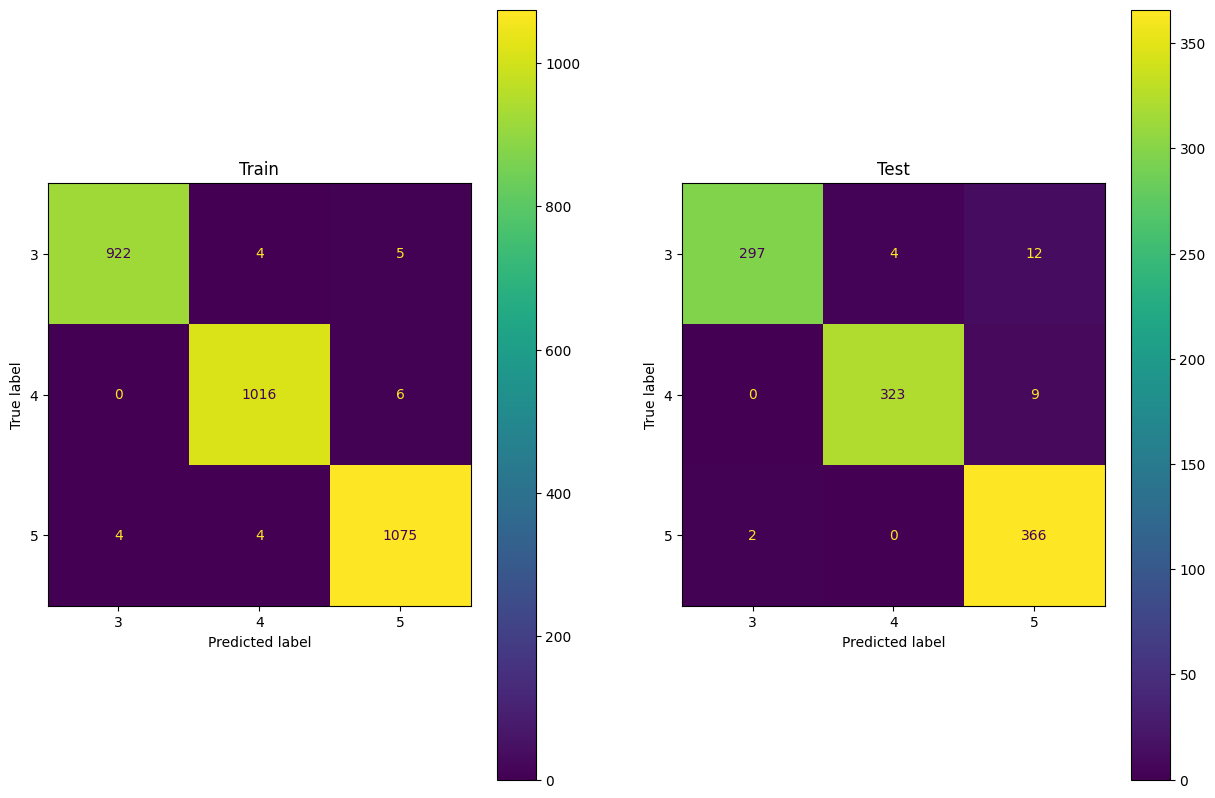

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

f, axes = plt.subplots(1, 2)
f.set_figwidth(15)
f.set_figheight(10)

train_cm = confusion_matrix(y_train, y_pred_train, labels=mnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=mnb.classes_)
axes[0].set_title('Train')
disp.plot(ax=axes[0])

test_cm = confusion_matrix(y_test, y_pred, labels=mnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=mnb.classes_)
axes[1].set_title('Test')
disp.plot(ax=axes[1])

plt.show()

# Model Tuning usando un pipeline

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

mnb_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

param_grid = {
    'cv__min_df': [0.0, 0.1, 0.2],
    'cv__max_df': [1.0, 0.9, 0.8],
    'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
gs_mnb = gs_mnb.fit(x_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [21]:
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'],
                           'cv score (mean)': cv_results['mean_test_score'],
                           'cv score (std)': cv_results['std_test_score']})
results_df = results_df.sort_values(by='rank').head()
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
34,1,"{'cv__max_df': 0.8, 'cv__min_df': 0.0, 'mnb__alpha': 1}",0.973321,0.006106
4,1,"{'cv__max_df': 1.0, 'cv__min_df': 0.0, 'mnb__alpha': 1}",0.973321,0.006106
19,1,"{'cv__max_df': 0.9, 'cv__min_df': 0.0, 'mnb__alpha': 1}",0.973321,0.006106
3,4,"{'cv__max_df': 1.0, 'cv__min_df': 0.0, 'mnb__alpha': 0.1}",0.969368,0.005267
18,4,"{'cv__max_df': 0.9, 'cv__min_df': 0.0, 'mnb__alpha': 0.1}",0.969368,0.005267


In [22]:
best_mnb_test_score = gs_mnb.score(x_test, y_test)
print('Test Accuracy :', best_mnb_test_score)

Test Accuracy : 0.9733464955577492


# Construcción del Pipeline de predicción

In [23]:
from sklearn.preprocessing import FunctionTransformer

def fix_document_encoding(doc):
    replacements = {
        'Ã¡': 'a',
        'Ã©': 'e',
        'Ã­': 'i',
        'Ã³': 'o',
        'Ãº': 'u',
        'Ã±': 'ñ'
    }

    for wrong, correct in replacements.items():
        doc = doc.replace(wrong, correct)
    return doc

def normalize_documents(doc):
    # Remove lower case and special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    doc = doc.lower()
    doc = doc.strip()

    tokens = wpt.tokenize(doc)
    filtered_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)

    return doc

fix_encoding = np.vectorize(fix_document_encoding)
normalize_corpus = np.vectorize(normalize_documents)

preprocessing_pipeline = Pipeline([
    ('fix_encoding', FunctionTransformer(fix_encoding)),
    ('normalize_corpus', FunctionTransformer(normalize_corpus)),
])

mnb_pipeline = Pipeline([
    ('cv', CountVectorizer(min_df=0., max_df=1.)),
    ('mnb', MultinomialNB(alpha=1.))
])

pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('clf', mnb_pipeline)
])


## Prueba del pipeline con train-test split

In [24]:
df_test = pd.read_excel('./ODScat_345.xlsx')

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df_test['Textos_espanol'], df_test['sdg'], test_size=0.25, random_state=1)

pipeline_model = pipeline.fit(x_train, y_train)

y_pred = pipeline_model.predict(x_test)

# Cross validation score
mnb_cv_scores = cross_val_score(pipeline_model, x_train, y_train, cv=5)
mnb_cv_mean_score = np.mean(mnb_cv_scores)
print(f"Cross Validation Score (5-fold): {mnb_cv_scores}")
print(f"Mean Cross Validation Score: {mnb_cv_mean_score}")

print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(metrics.classification_report(y_test, y_pred))

Cross Validation Score (5-fold): [0.97039474 0.97693575 0.96375618 0.98187809 0.97364086]
Mean Cross Validation Score: 0.9733211219977456
Accuracy: 0.9733464955577492
              precision    recall  f1-score   support

           3       0.99      0.95      0.97       313
           4       0.99      0.97      0.98       332
           5       0.95      0.99      0.97       368

    accuracy                           0.97      1013
   macro avg       0.98      0.97      0.97      1013
weighted avg       0.97      0.97      0.97      1013



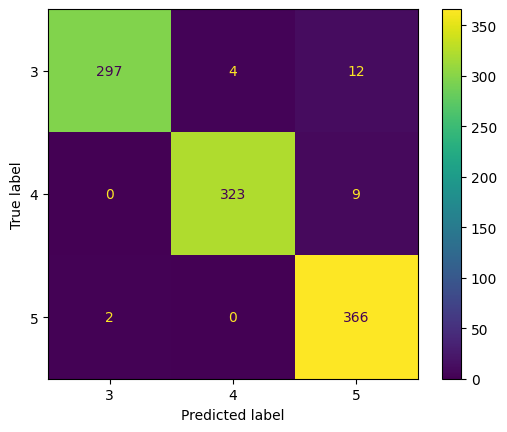

In [26]:
pipeline_cm = confusion_matrix(y_test, y_pred, labels=pipeline_model.named_steps['clf'].named_steps['mnb'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=pipeline_cm, display_labels=pipeline_model.named_steps['clf'].named_steps['mnb'].classes_)
disp.plot()
plt.show()

### Encontrar palabras más importantes por cada clase

In [27]:
def get_salient_words(nb_clf, vect, class_ind):
    words = vect.get_feature_names_out()
    zipped = list(zip(words, nb_clf.feature_log_prob_[class_ind]))
    sorted_zip = sorted(zipped, key=lambda t: t[1], reverse=True)

    return sorted_zip

class_1 = get_salient_words(pipeline_model.named_steps['clf'].named_steps['mnb'], pipeline_model.named_steps['clf'].named_steps['cv'], 0)
class_2 = get_salient_words(pipeline_model.named_steps['clf'].named_steps['mnb'], pipeline_model.named_steps['clf'].named_steps['cv'], 1)
class_3 = get_salient_words(pipeline_model.named_steps['clf'].named_steps['mnb'], pipeline_model.named_steps['clf'].named_steps['cv'], 2)

In [28]:
word_importances = pd.DataFrame({'ODS_3': class_2, 'ODS_4': class_3, 'ODS_5': class_1})
word_importances.head(5)

,ODS_3,ODS_4,ODS_5
0,"(educacin, -4.361143423757457)","(mujer, -3.4908966616291117)","(salud, -4.07722680909881)"
1,"(escuela, -4.4542338468234695)","(gnero, -4.2177572974720166)","(atencin, -4.36549078438924)"
2,"(estudiant, -4.552842142364009)","(ms, -4.756753798204704)","(ms, -4.670789284229319)"
3,"(ms, -4.743543258934626)","(hombr, -4.883505503843848)","(servicio, -4.842738282207651)"
4,"(docent, -5.043240768130818)","(poltica, -5.200904048624106)","(pacient, -5.283529259207556)"


In [29]:
word_importances_categories = [
    [word[0] for word in word_importances['ODS_3']],
    [word[0] for word in word_importances['ODS_4']],
    [word[0] for word in word_importances['ODS_5']]
]

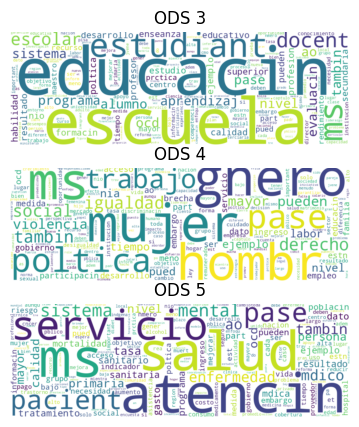

In [30]:
f, axes = plt.subplots(3, 1, figsize=(15, 5))

for i, words in enumerate(word_importances_categories):
  word_freq = Counter()
  total_words = word_importances.shape[0]
  for position, word in enumerate(words):
    weight = total_words - position
    word_freq[word] += weight
  wordcloud = WordCloud(width=1200, height=400, background_color='white').generate_from_frequencies(word_freq)
  axes[i].imshow(wordcloud, interpolation='bilinear')
  axes[i].set_title(f'ODS {i+3}')
  axes[i].axis('off')

plt.show()



# Generación de resultados de validación con el pipeline

In [31]:
df_test = pd.read_excel('./TestODScat_345.xlsx')
x_data = df_test['Textos_espanol']
y_pred_test = pipeline_model.predict(x_data)

FileNotFoundError: [Errno 2] No such file or directory: './TestODScat_345.xlsx'

In [ ]:
df_test['sdg'] = y_pred_test
df_test.to_excel('./TestODScat_345_pred.xlsx', index=False)
df_test.to_csv('./TestODScat_345_pred.csv', index=False)

# Serialización de modelo

In [ ]:
import joblib
import cloudpickle

serialized = cloudpickle.dumps(pipeline_model)
open('pipeline_model.pkl', 'wb').write(serialized)

893413